In [25]:
import os, pandas as pd, numpy as np, cv2
from torchvision.datasets import FashionMNIST

os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed/images", exist_ok=True)



In [26]:
classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
           "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

train = FashionMNIST("data/raw", train=True, download=True)
test = FashionMNIST("data/raw", train=False, download=True)

def save_split(ds, split):
    rows = []
    for i, (img, label) in enumerate(ds):
        arr = np.array(img)
        arr = cv2.resize(arr, (224,224))
        rgb = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
        fname = f"{split}_{i:06d}.png"
        path = f"data/processed/images/{fname}"
        cv2.imwrite(path, rgb)
        rows.append({"image_path": path, "type": classes[label], "color": "gray"})
    return rows

rows = save_split(train, "train") + save_split(test, "test")
pd.DataFrame(rows).to_csv("data/processed/labels.csv", index=False)



In [27]:
df = pd.read_csv("data/processed/labels.csv")
print(df.head())
print(df['type'].value_counts().head())


                               image_path         type color
0  data/processed/images/train_000000.png   Ankle boot  gray
1  data/processed/images/train_000001.png  T-shirt/top  gray
2  data/processed/images/train_000002.png  T-shirt/top  gray
3  data/processed/images/train_000003.png        Dress  gray
4  data/processed/images/train_000004.png  T-shirt/top  gray
type
Ankle boot     7000
T-shirt/top    7000
Dress          7000
Pullover       7000
Sneaker        7000
Name: count, dtype: int64


In [28]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [29]:
transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)


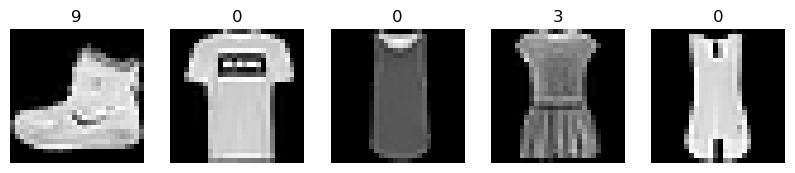

In [30]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = train_data[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')
plt.show()



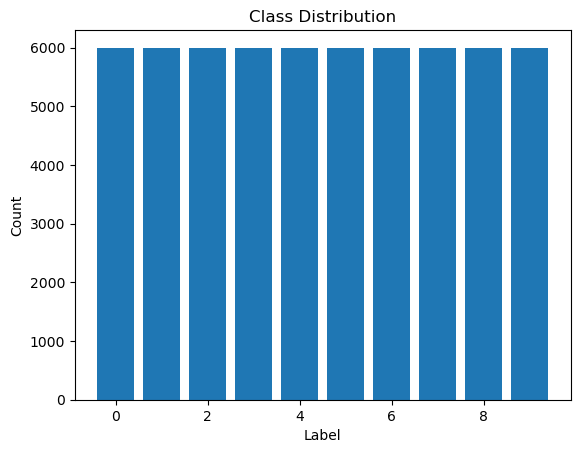

In [31]:
labels = [label for _, label in train_data]
plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.8)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [32]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64)


In [33]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNN()


In [34]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.6949
Epoch 2, Loss: 0.5800
Epoch 3, Loss: 0.2479


In [35]:
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy: {100 * correct / total:.2f}%")


Accuracy: 85.93%


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [37]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [39]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64)


In [40]:
for epoch in range(5):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


Epoch 1 | Loss: 0.2452
Epoch 2 | Loss: 0.1765
Epoch 3 | Loss: 0.5022
Epoch 4 | Loss: 0.2550
Epoch 5 | Loss: 0.2288


In [41]:
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")



Test Accuracy: 92.27%


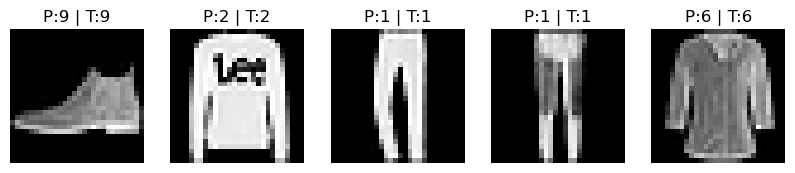

In [42]:
import matplotlib.pyplot as plt

images, labels = next(iter(test_loader))
with torch.no_grad():
    output = model(images)
pred = output.argmax(dim=1)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"P:{pred[i].item()} | T:{labels[i].item()}")
    axes[i].axis('off')
plt.show()


In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

acc = accuracy_score(all_labels, all_preds)
prec_macro = precision_score(all_labels, all_preds, average="macro", zero_division=0)
rec_macro = recall_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"Test Accuracy: {acc * 100:.2f}%")
print(f"Macro Precision: {prec_macro:.3f}")
print(f"Macro Recall: {rec_macro:.3f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)


Test Accuracy: 92.27%
Macro Precision: 0.924
Macro Recall: 0.923
Confusion matrix:
 [[888   0  10   5   5   1  87   0   4   0]
 [  4 978   0  11   2   0   4   0   1   0]
 [ 18   1 837   8  81   0  54   0   1   0]
 [ 21   3   8 922  27   0  16   0   3   0]
 [  1   1  14  13 926   0  44   0   1   0]
 [  0   0   0   0   0 992   0   8   0   0]
 [ 97   1  35  19  65   0 777   0   6   0]
 [  0   0   0   0   0  10   0 980   0  10]
 [  3   0   2   8   0   2   3   2 980   0]
 [  0   0   0   0   0  13   0  40   0 947]]


In [44]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]




In [45]:
mis_idx = np.where(all_labels != all_preds)[0]
print(f"Total misclassifications: {len(mis_idx)}")

from collections import Counter

pairs = list(zip(all_labels[mis_idx], all_preds[mis_idx]))
pair_counts = Counter(pairs).most_common(10)

print("Most frequent misclassifications (true -> predicted, count):")
for (t, p), c in pair_counts:
    true_name = class_names[t] if t < len(class_names) else str(t)
    pred_name = class_names[p] if p < len(class_names) else str(p)
    print(f"{true_name} -> {pred_name}: {c}")




Total misclassifications: 773
Most frequent misclassifications (true -> predicted, count):
Shirt -> T-shirt/top: 97
T-shirt/top -> Shirt: 87
Pullover -> Coat: 81
Shirt -> Coat: 65
Pullover -> Shirt: 54
Coat -> Shirt: 44
Ankle boot -> Sneaker: 40
Shirt -> Pullover: 35
Dress -> Coat: 27
Dress -> T-shirt/top: 21


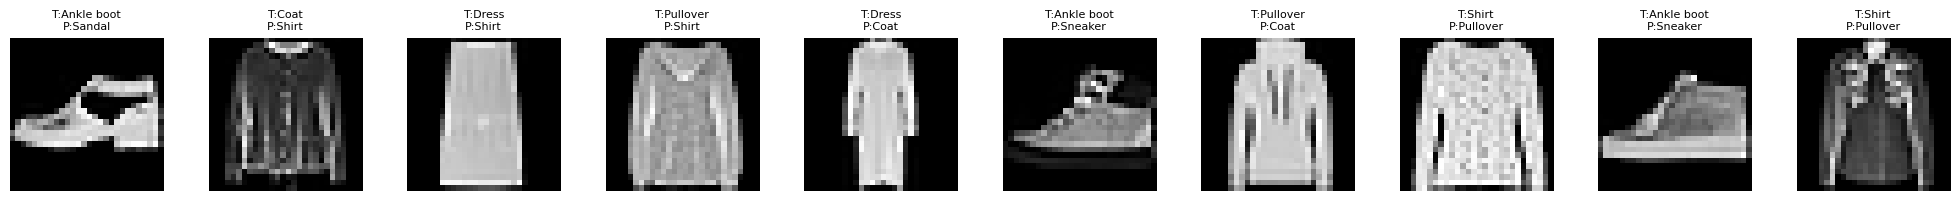

In [46]:
def show_misclassified(n=10):
    n = min(n, len(mis_idx))
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    for i, idx in enumerate(mis_idx[:n]):
        img, true_label = test_data[idx]   # uses your existing test_data
        pred_label = all_preds[idx]

        ax = axes[i] if n > 1 else axes
        ax.imshow(img.squeeze(), cmap="gray")
        ax.axis("off")
        ax.set_title(f"T:{classes[true_label]}\nP:{classes[pred_label]}", fontsize=8)

    plt.tight_layout()
    plt.show()

show_misclassified(10)



In [47]:
import torch

torch.save(model.state_dict(), "fashion_cnn.pth")
print("Saved model to fashion_cnn.pth")


Saved model to fashion_cnn.pth
